In [74]:
# import relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import os
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
rd.seed(90)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import ipywidgets as widgets
from IPython.display import display
from matplotlib.cm import get_cmap
import flowkit as fk
import bokeh
from bokeh.plotting import show
import matplotlib.colors as mcolors
import hdbscan

In [35]:
# import data for viSNE
csv_path = r"C:\Users\bruno\OneDrive\Desktop\Programmer\viSNE_maps_and_data\Data\SingleSpeciesData"
definitions_dict = {
        "3B": 1,
        "3D": 2,
        "3G": 3,
        "A26": 4,
        "MP": 5,
        "CK":6,
        "CM":7,
        "FeOx":8,
        "Q12":9

    }

def label_data_according_to_definitions(csv_path,definitions_dict= None):
    """
    Function creates matrix and labels them according to filename naming.
    If no definitions dict is given then the whole filename is used to name the events

    csv_path: contains the path of your csv files
    definitions_dict: contains the matching suffix or prefix (unique), which matches corresponding labels
    
    return: returns a labeld data set from all the csv files in the dictionary
    """
    labeled_dfs = []
    

    for filename in os.listdir(csv_path):
        file_path = os.path.join(csv_path, filename)
        if filename.endswith(".csv"):  # Check if the file is a CSV file
            df = pd.read_csv(file_path)
            if definitions_dict is not None:
                for key, label in definitions_dict.items():
                    if key in filename:
                        df['Label'] = label  # Add a new column 'Label' with the corresponding label
                        labeled_dfs.append(df)
                        break  # No need to check other keys once a match is found
            elif definitions_dict is None:
                df['Label']= filename
                labeled_dfs.append(df)

    return labeled_dfs


# label data 
labeld_dfs = label_data_according_to_definitions(csv_path)

In [24]:
def load_fcs_from_dir(directory_path):
    """ 
    Loads in the events in the matrix from the given directory

    Parameters:
    - directory_path: path of the directory

    Return: 
    - returns list of dataframes of all Area columns in question, no transformation is applied
    """
    fcs_files = []
    # Iterate through files in the directory
    for file in os.listdir(directory_path):
        if file.endswith(".fcs"):
            file_path = os.path.join(directory_path, file)
            try:
                fcs_data = fk.Sample(file_path,cache_original_events=True)
                fcs_data_df = fcs_data.as_dataframe(source="orig")
                fcs_data_df = fcs_data_df[[col for col in fcs_data_df.columns if col[0].endswith('-A')]]
                fcs_data_df.columns = fcs_data_df.columns.droplevel(0)
                fcs_files.append(fcs_data_df)
            except Exception as e:
                print(f"An error occurred while processing {file}: {e}")
    return fcs_files

direct = r"C:\Users\bruno\OneDrive\Desktop\Programmer\viSNE_maps_and_data\Data\fcm_field_data"
fcs_files = load_fcs_from_dir(direct)

In [68]:
# write subsampling function

def subsample_from_list_of_df(list_of_dataframes, subsampling_number=300, random_seed=None):
    """
    Subsample rows from each DataFrame in a list and concatenate them together.

    Parameters:
    - list_of_dataframes: List of pandas DataFrames to subsample from.
    - subsampling_number: Number of rows to subsample from each DataFrame.
    - random_seed: Seed for random number generation (for reproducibility).

    Returns:
    - Concatenated DataFrame containing the subsampled rows.
    """
    # Set random seed for reproducibility
    if random_seed is not None:
        np.random.seed(random_seed)
    
    # Initialize an empty list to store the subsampled DataFrames
    subsampled_dfs = []
    
    for df in list_of_dataframes:
        # Check if the subsampling number is greater than the number of rows in the DataFrame
        if subsampling_number >= len(df):
            subsampled_dfs.append(df)  # Append the entire DataFrame
        else:
            # Randomly sample 'subsampling_number' rows without replacement
            subsampled_df = df.sample(n=subsampling_number, replace=False)
            subsampled_dfs.append(subsampled_df)
    
    # Concatenate the subsampled DataFrames into one DataFrame
    concatenated_df = pd.concat(subsampled_dfs, ignore_index=True)
    
    return concatenated_df

#subsampling_df = subsample_from_list_of_df(labeld_dfs,subsampling_number=2000)
subsampling_df_fcs_transformed = subsample_from_list_of_df(fcs_files,subsampling_number=3000,random_seed=42)

In [31]:
def asinh_transform(subsampling_df, factor=150):
    """
    Apllies the asinh transformation on each column in one dataframe, also apllies a min max normalization

    Parameters:
    - subsampling_df : Dataframe
    - factor : Scaling factor that apllies like x= asinh(x/factor)

    Return:
    - transformed dataframe
    """
    transformed_df = subsampling_df.copy()  # Create a copy to store the transformed data
    for col_name in subsampling_df.columns:
        if col_name != 'Label' and pd.api.types.is_numeric_dtype(subsampling_df[col_name]):
            col = subsampling_df[col_name]
            transformed_df[col_name] = np.arcsinh(col / factor)

            # Min-max normalization
            col_min = transformed_df[col_name].min()
            col_max = transformed_df[col_name].max()
            transformed_df[col_name] = (transformed_df[col_name] - col_min) / (col_max - col_min)

    return transformed_df

transformed_dataframes_data = asinh_transform(subsampling_df_fcs_transformed, factor=150)

In [145]:
# create tSNE map and contatenate dataframe with labels


NameError: name 'subsampling_df' is not defined

In [ ]:

tsne_result = TSNE(n_components=2, perplexity=50, verbose=True).fit_transform(transformed_dataframes)

C:\Users\bruno\AppData\Local\Temp\ipykernel_12136\696012636.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  distinct_colors= get_cmap("tab10")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


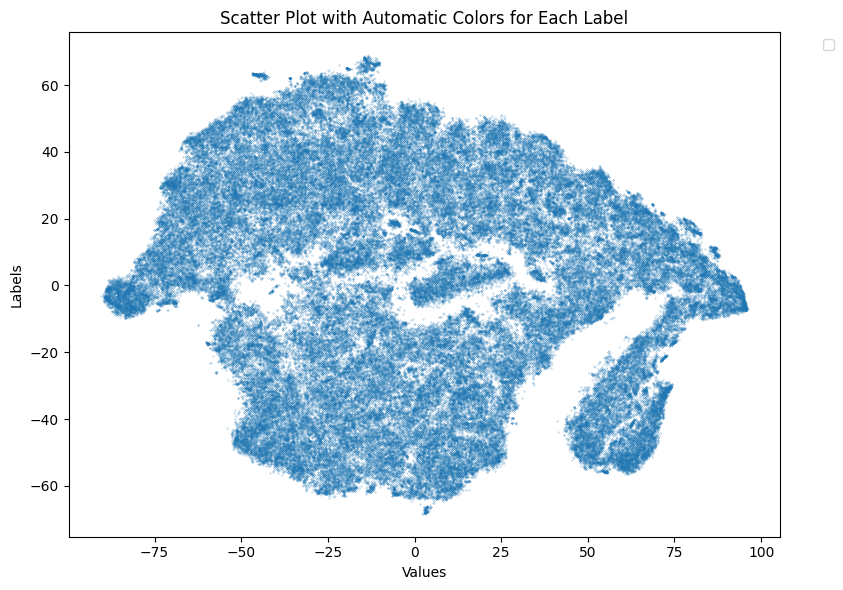

In [85]:
def get_distinct_colors(n):
    """
    Gets unique colors

    Parameters:
    - n : amount of colors to create

    Return
    - Different colors 
    """
    colors = list(mcolors.TABLEAU_COLORS)
    while len(colors) < n:
        colors += colors
    return colors[:n]


def plot_vsne_result_generic(tsne_result, label_col):
    """
    Creates a generic vsne map from a tsne implementation 

    Parameters:
    - tsne_result : embedded tsne_result from TSNE function 
    - label_col : column that shoud be used to label the events in the viSNE

    Returns:
    - ()
    
    """
    x = tsne_result[:, 0]
    y = tsne_result[:, 1]
    if label_col is not None:
        distinct_colors = get_distinct_colors(len(label_col))  # Adjust the number of colors as needed
    else:
        distinct_colors= get_cmap("tab10")
    # Create a scatter plot with automatic colors for each label
    plt.figure(figsize=(8, 6))

    # Get unique labels
    if label_col is not None:
        unique_labels = label_col.unique()
        # Scatter plot with automatic colors
        for i, label in enumerate(unique_labels):
            plt.scatter(x[label_col == label], y[label_col == label], label=label, color=distinct_colors[i], alpha=0.7, s=0.05)
    else:
            plt.scatter(x, y, alpha=0.7, s=0.05)

    # Customize plot labels and title
    plt.xlabel('Values')
    plt.ylabel('Labels')
    plt.title('Scatter Plot with Automatic Colors for Each Label')
    plt.tight_layout()

    # Add a legend outside the figure
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Show the plot
    plt.show()


plot_vsne_result_generic(tsne_result,label_col=None)

In [10]:
# create interactive plot to change coloring scheme with a dropdown menu 
def create_visne_with_dropdown(tsne_result,subsampling_df):
        """
        creates viSNE Map with coloring according to different input columns which can be switched through a dropdown menu

        Parameters:
        - tsne_result: Coordidnates in the viSNE Map created from subsampling_df
        - subsampling_df: a df of subsampled accordingly from original dataframes
        
        
        """
        data = {
                "X1":tsne_result[:,0],
                "X2":tsne_result[:,1]

        }

        df = pd.DataFrame(data)

        color_matrix = subsampling_df

        def update_scatter_plot(selected_col_for_coloring):
                plt.figure(figsize=(8,6))
                scatter = plt.scatter(df["X1"], df["X2"], c = color_matrix[selected_col_for_coloring], cmap="rainbow",s=0.01)
                plt.colorbar(scatter,label="Strenght")
                plt.show()

        coloring_scheme = widgets.Dropdown(
                options = color_matrix.columns,
                description = "Select Col for coloring: ",
                continuous_update = False

        )

        widgets.interactive(update_scatter_plot,selected_col_for_coloring=coloring_scheme)
        interactive_plot = widgets.interactive(update_scatter_plot, selected_col_for_coloring=coloring_scheme)
        return interactive_plot
    
    # Display the interactive widget

create_visne_with_dropdown(tsne_result,transformed_dataframes)

interactive(children=(Dropdown(description='Select Col for coloring: ', options=('FS', 'SS', 'FL1 510/20', 'FL…

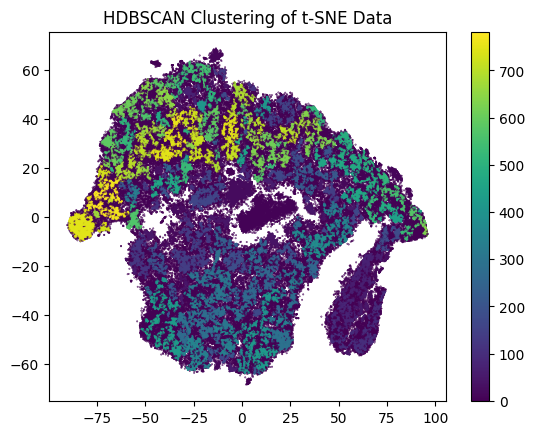

In [21]:
# automatic clustering 

def cluster_tsne_map(tsne_result,m=30,s=5):
    """
    Functions to automatically cluster the viSNE map via HDBSCAN

    Parameters:
    - tnse_result : embedded TNSE coordinates 
    - m : value for the HDBSAN, minimal cluster size
    - s: value minimal cluster


    Retruns:
    - ()
    
    
    """

    clusterer = hdbscan.HDBSCAN(min_cluster_size=m, min_samples=s)
    cluster_labels = clusterer.fit_predict(tsne_result)

    # Visualize the clusters
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=cluster_labels, cmap='viridis', marker='.', s= 0.5)
    plt.colorbar()
    plt.title('HDBSCAN Clustering of t-SNE Data')
    plt.show()

In [67]:
# implement clustering based on mchine learning$

# implement machine learning model, use Y to predict labels
def develop_ML_model_RF(labeld_dfs, random_state = 42, test_size= 0.2):

    """
    Creates a machine learning model with the random forest classifier and prints a report

    Parameters:
    - labeld_dfs : labeled dataframe conataining a label column
    - random state : seed to use 
    - test_size : amount of data to use as a test case 

    Returns:
    - random forest classifier
    
    
    
    """
    combined_df = pd.concat(labeld_dfs,ignore_index=True)
    combined_df_trans = asinh_transform(combined_df)
    combined_df_rand= combined_df_trans.sample(frac=1,random_state=random_state).reset_index(drop=True)
    train_df, test_df = train_test_split(combined_df_rand,test_size,random_state=42)
    X_train = train_df.drop("Label",axis=1)
    y_train = train_df["Label"]

    X_test = test_df.drop("Label", axis=1)
    y_test = test_df["Label"]


    rf_class= RandomForestClassifier(n_estimators=200, random_state=42)

    rf_class.fit(X_train,y_train)


    y_pred = rf_class.predict(X_test)

    accuracy = accuracy_score(y_test,y_pred)
    report = classification_report(y_test,y_pred)

    print(f"accuracy:{accuracy:.2f}")
    print("Classification Report:")
    print(report)
    return rf_class


accuracy:0.82
Classification Report:
                                        precision    recall  f1-score   support

                  Cyano-AnabaenaSp.csv       0.67      0.84      0.75       760
       Cyano-Chamaesiphonpolonicus.csv       0.99      0.99      0.99       771
                   Cyano-LyngbyaSp.csv       0.50      0.03      0.06        30
          Cyano-Merismopodiaglauca.csv       0.90      0.96      0.93      1382
               Cyano-MicrocystisSp.csv       0.97      0.98      0.98       756
                Cyano-PhormidiumSp.csv       0.83      0.85      0.84       665
       Cyano-Pseudoanabaenagaleata.csv       0.92      0.92      0.92      1048
               Diatom-AchnanthesSp.csv       0.79      0.88      0.83       767
Diatom-AchnantidiumminutissimumTCC.csv       0.80      0.89      0.84       720
        Diatom-Cocconeisplacentula.csv       0.72      0.75      0.73       688
           Diatom-Craticulaacomoda.csv       0.84      0.82      0.83       815
  

In [68]:
dir_data= r"C:\Users\bruno\OneDrive\Desktop\Programmer\viSNE_maps_and_data\Data\fcm_field_data\Extracted_Data"

# load csv only ending with e 
def load_csv_with_ending(dir_data,ending="_e"):
    """
    Loads csv files with a certain ending 

    Parameters:
    - dir_data : where the files are located, directory paths
    - ending : the ending to look out for 

    Returns:
    - dataframe from the direcotry 
    
    
    """
    input_df = []
    for filename in os.listdir(dir_data):
        file_path = os.path.join(dir_data, filename)
        if filename.endswith(f"{ending}.csv"):  # Check if the file is a CSV file
            df = pd.read_csv(file_path)
            
            # Add a new column 'filename' with the current filename
            df['filename'] = filename
            
            input_df.append(df)
    return input_df

input_df = load_csv_with_ending(dir_data)
subsampling_input_df= subsample_from_list_of_df(input_df,1000,42)
input_df_transformed= asinh_transform(subsampling_input_df,factor=150)

51


In [70]:
def rename_columns(input_df, column_mapping):

    """
    Renames columns if feature names are not equivalent

    Parameters:
    - input_df : Dataframe to rename 
    - column_mapping: dict with old:new names 

    Returns:
    - renamed dataframes
    
    """
    # Create a copy of the DataFrame to avoid modifying the original
    renamed_df = input_df.copy()

    # Rename columns based on the provided mapping
    renamed_df.rename(columns=column_mapping, inplace=True)

    return renamed_df

# Define the mapping from current column names to expected feature names
column_mapping = {
    'FL1 510/20': 'FL1_Area',
    'FL10 525': 'FL10_area',
    'FL2 542/27': 'FL2_area',
    'FL3 575': 'FL3_area',
    'FL4 620/30': 'FL4_area',
    'FL5 695/30': 'FL5_area',
    'FL6 660': 'FL6_area',
    'FL7 725/20': 'FL7_area',
    'FL8 755': 'FL8_area',
    'FL9 450/50': 'FL9_area',
    "FS":"FS_area",
    "SS": "SS_area"

}

# Call the function to rename the columns
subsampling_df_fcs_transformed = asinh_transform(subsampling_df_fcs_transformed)
subsampling_df_fcs_transformed = rename_columns(subsampling_df_fcs_transformed, column_mapping)

In [71]:


ML_labels = rf_class.predict(subsampling_df_fcs_transformed)

subsampling_df_fcs_transformed["ML_Labels"]= ML_labels

In [ ]:
# create viSNE map with dropdown for all cols, hdbscan analysis, ML labeling

tsne_result_input = TSNE(n_components=2, perplexity=30, verbose=True,method="barnes_hut").fit_transform(subsampling_df_fcs_transformed.iloc[:,:-1])

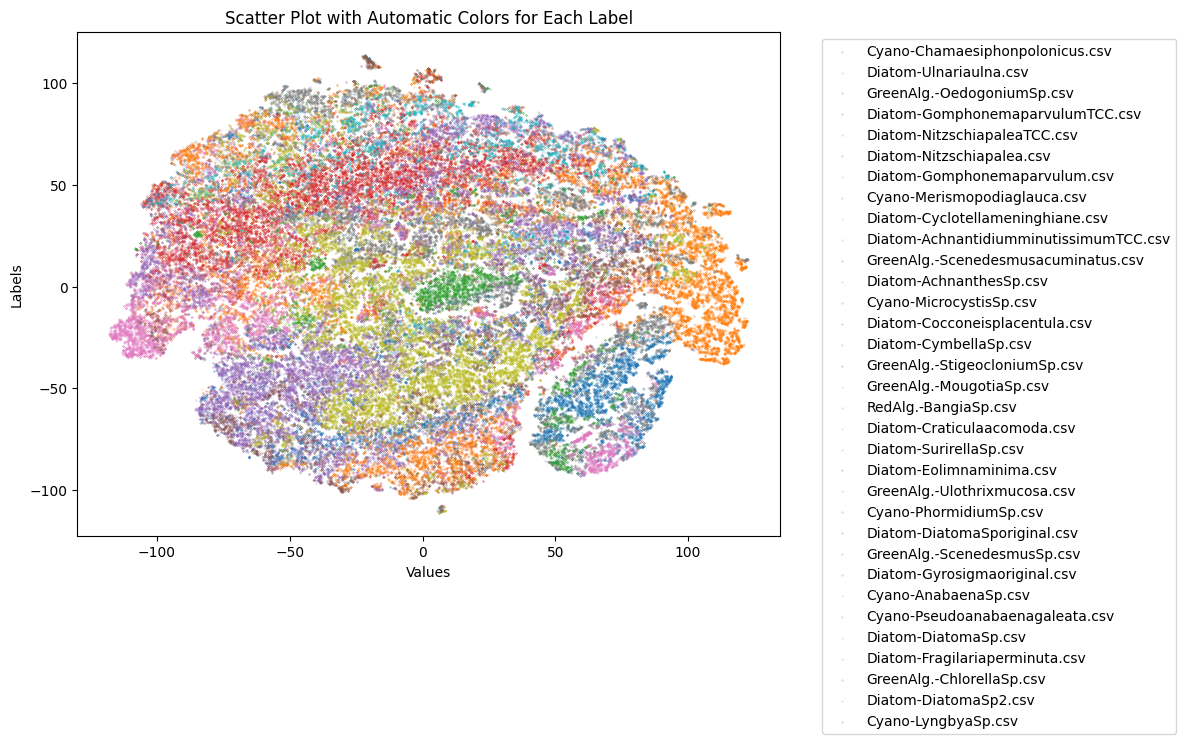

In [86]:
plot_vsne_result_generic(tsne_result_input,label_col=subsampling_df_fcs_transformed["ML_Labels"])

In [63]:
i_plot = create_visne_with_dropdown(tsne_result_input,input_matrix)
display(i_plot)

interactive(children=(Dropdown(description='Select Col for coloring: ', options=('FS', 'SS', 'FL1 510/20', 'FL…